下圖為本章model的架構,與上一章(16.2)差不多,唯一的差別在於本章使用CNN來提取text特徵

-----
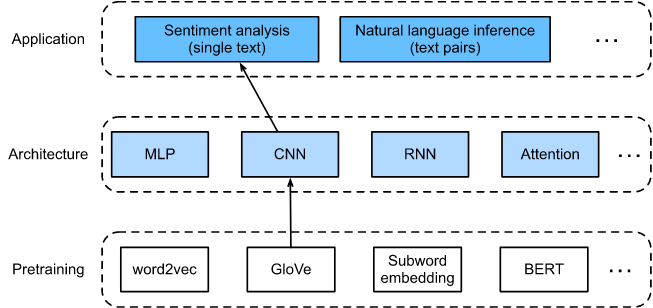

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

#### 16.3.1. One-Dimensional Convolutions
下圖為conv1d, kernel在input上由左向右滑動,路徑上做inner-product,產生output
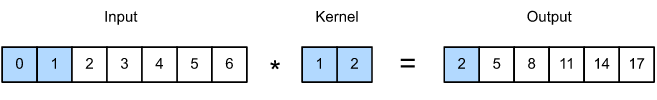

In [2]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [3]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

下圖為針對多個channel 1d input做探討,kernel channel number = input channel number, convolution做作法就是做多個conv1d並求和
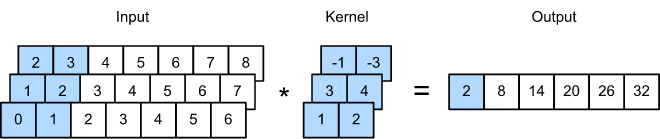

In [4]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

此圖為上圖將多個1d data合併的結果, 可將其視為從muti-input-channel one-dimensional cross-correlational轉變為singal-input-channel two-dimensional cross-correlation

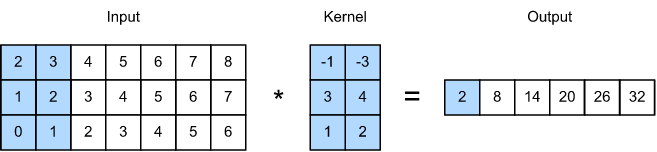

#### 16.3.2. Max-Over-Time Pooling
取最大值,作為output

#### 16.3.3. The textCNN Model

`layer1 (input layer):` 

將input視為(batch, seq len, embedding dim) = (1,11,6), conv kernel size = 2,4  
permute(0, 2, 1) -> (1, 6, 11)

`layer2 (conv layer): ` 

conv kernel分別對input的每個channel做conv1d, 並設置output channel = 4,5, 分別得到(1, 4, 10),(1, 5, 8)的output  

`layer3 (max-pooling):`  

針對每個token的feature(channel)做maxpooling,合併得到最後的repr   

`layer4 (fc-layer):`  

針對CNN提取的特徵做分類任務

`The model architecture of textCNN:`
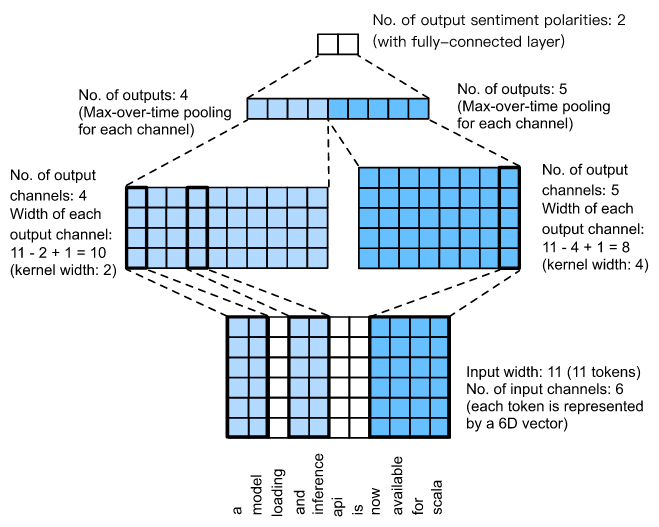

`補`torch.sqeeze: dim reduce / torch.unsqueeze: dim expend

`補`conv1d:  
conv1d經常應用在input為文本的任務,與img多為2d不同,text為1d,所以給定一些參數試著去用文字描述conv1d運作的過程 

***parameter:***  
    batch = 8 /  
    seq length = 35 /  
    embedding dim = 256  /  
    kernel size = 4  /   
    channel num = 100 /  
    
    
---
**(step 1.)**   

intput shape: (8, 35, 256)   

**(step 2.)** 

因爲conv1d作用在最後一個維度,而我們要針對seq length做conv,因此要做permute(0,2,1),作維度調換  

**(step 3.)** 

(以下圖做舉例)  
kernel size = (kernel size, embedding dim)  
使用不同的conv kernel, 對input seq做conv -> (output) seq length = input seq length - kernel size +1 / channel = num of kernel  

**(step 4.)** 

output shape: (8, 100, 32)


 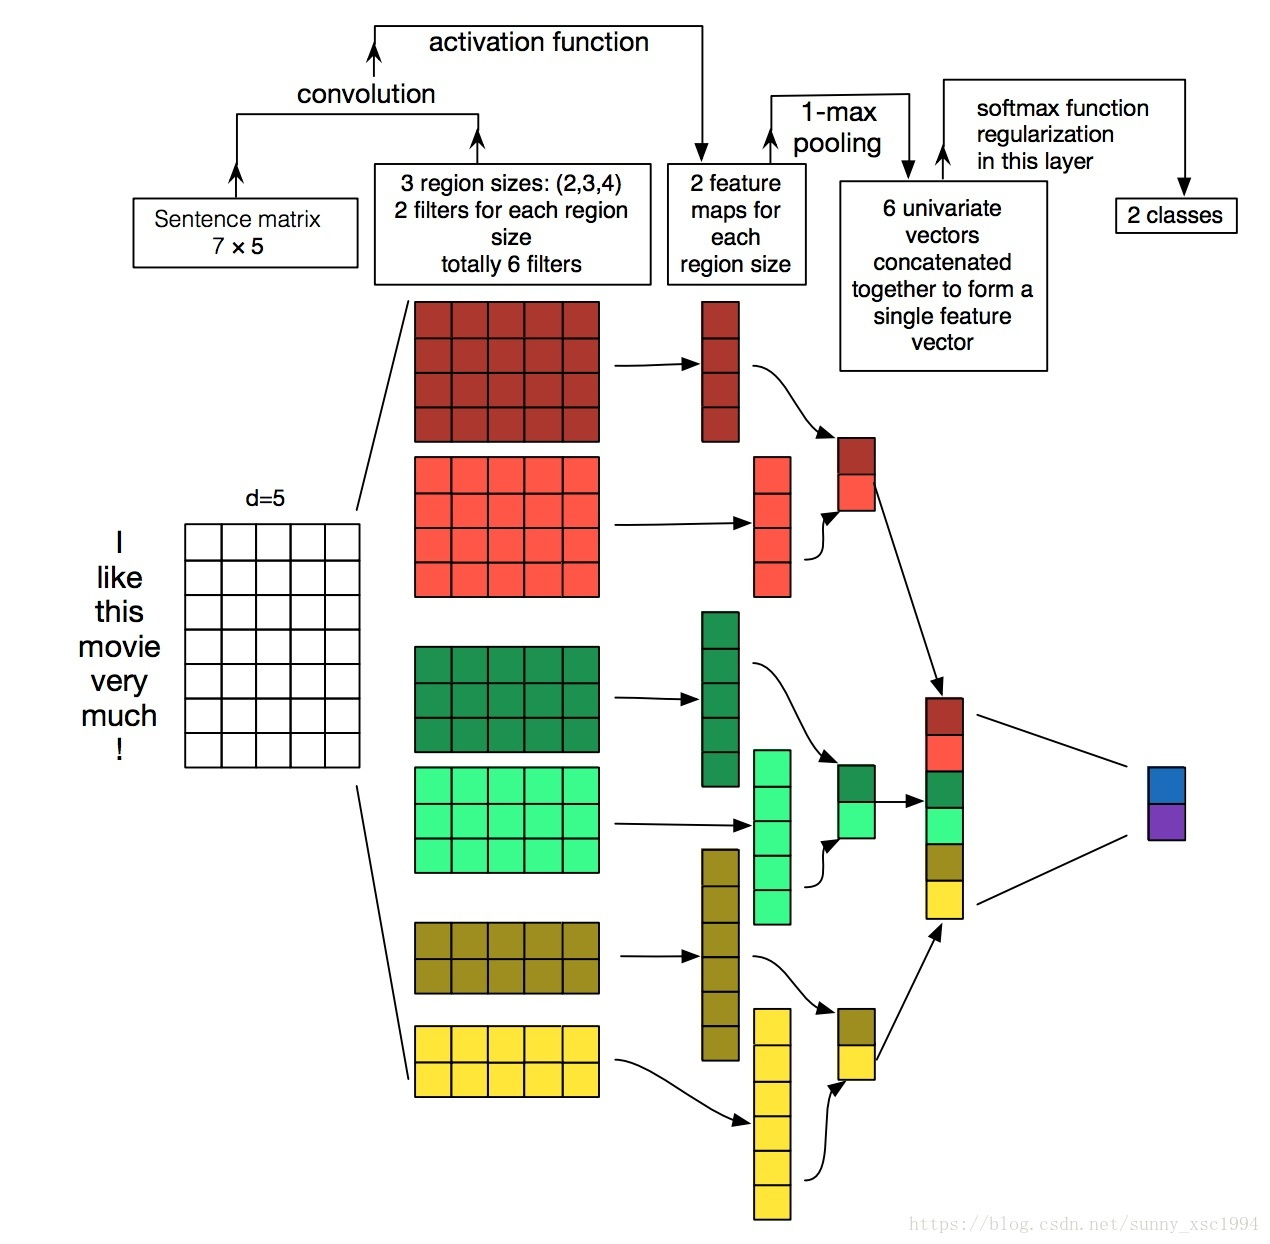

In [5]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [6]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

`[補]`
nn.embedding.weight.data.copy_: 加載自己訓練好的embedding vector

In [7]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

本地端沒有gpu會報錯,在colab上試跑

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

`reference:`  
https://blog.csdn.net/sunny_xsc1994/article/details/82969867  
http://www.d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-cnn.html